In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

These changes are implemented in the new architecture: GNNRecommenderwithSkipConnections. To summarise, there are 3 changes from the BaseGNNRecomender:

1. Added skip connections
2. Added batch norm layers
3. Simplified MLP predictor to single feedforward layer

# Imports

In [2]:
import pandas as pd
import pickle
import numpy as np
import torch
import os

from utils.setup_nodes import create_edge_lists, create_user_df
from utils.graph_helpers import train_model, plot_train_val_loss, final_evaluation, plot_activation_heatmap_and_density
from utils.graph_model import GNNRecommenderwithSkipConnections
from utils.general import seed_everything
from utils.predictions import recommend_products, pretty_print_recomendations, get_top_k_preds

# Set up

In [3]:
seed_everything()

In [4]:
user_split = "train_test_valid"
prod_embed_name = "meta_features_512"
user_embed_name = "user_reviews_features_512"

data_dir = "data"
product_dir = "full_data"
embedding_dir = "embedding"
results_folder = "complex_gnn"

device = "cuda"

product_cols = ["parent_asin", "average_rating", "rating_number"]
user_cols = ["user_id", "rating_mean", "rating_count", "helpful_vote_mean", "helpful_vote_gte_1", "verified_purchase_mean", "last_active_in_days_min",
            "last_active_in_days_max", "word_count_mean"]
edge_cols = ["user_id", "parent_asin", "rating"]

fill_users = "zero"

# Load data

In [5]:
product_df = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = product_cols)
train_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/train_agg.parquet", columns = user_cols)
train_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/train.parquet", columns = edge_cols)

if user_split == "train_test_valid":
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/valid_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/valid.parquet", columns = edge_cols)
else:
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/test_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/test.parquet", columns = edge_cols)


In [6]:
product_embedding = torch.load(f"{data_dir}/{embedding_dir}/product/{prod_embed_name}.pt")
train_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/train_{user_embed_name}.pt")
if user_split == "train_test_valid":
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/valid_{user_embed_name}.pt")
else:
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/test_{user_embed_name}.pt")

# Make nodes

In [7]:
# Add the embedding 
train_user_df["embedding"] = list(train_user_embedding.numpy())
test_user_df["embedding"] = list(test_user_embedding.numpy())

# Make super user df
user_df = create_user_df(train_user_df, test_user_df)

In [8]:
# Set up id mapping
offset = user_df.user_id.nunique()
user_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(user_df.user_id.unique())}
prod_id_to_idx = {unique_id : offset + idx for idx, unique_id in enumerate(product_df.parent_asin.unique())}

# Add to df
product_df["prod_idx"] = product_df.parent_asin.apply(lambda x: prod_id_to_idx[x])
train_user_edges["user_idx"] = train_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
test_user_edges["user_idx"] = test_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
train_user_edges["prod_idx"] = train_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])
test_user_edges["prod_idx"] = test_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])

In [9]:
# Concat product nodes 
product_nodes = torch.cat([torch.tensor(product_df.drop(["parent_asin", "prod_idx"], axis = 1).to_numpy()), product_embedding], dim = 1)

In [10]:
# concat user nodes 
user_embed = torch.tensor(np.vstack(user_df["embedding"].values))
user_info = torch.tensor(user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
user_nodes = torch.cat([user_info, user_embed], dim = 1)

In [11]:
# Create edge list
train_edge_index, train_edge_weights = create_edge_lists(train_user_edges)
test_edge_index, test_edge_weights = create_edge_lists(train_user_edges)

# Move to GPU 

In [12]:
product_nodes = product_nodes.type(torch.float).to(device)
user_nodes = user_nodes.type(torch.float).to(device)
train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)

# Model

In [13]:
# Set up model features
num_users = len(user_df)
num_products = len(product_df)
user_feature_dim = user_nodes.shape[1]
product_feature_dim = product_nodes.shape[1]
embedding_dim = 64

In [14]:
# Instantiate the model
model = GNNRecommenderwithSkipConnections(num_users, num_products, user_feature_dim, product_feature_dim, embedding_dim)

In [15]:
# move the model 
model.to(device)

GNNRecommenderwithSkipConnections(
  (user_feature_transform): Linear(in_features=776, out_features=64, bias=True)
  (product_feature_transform): Linear(in_features=770, out_features=64, bias=True)
  (conv1): GCNConv(64, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(64, 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): Linear(in_features=64, out_features=1, bias=True)
)

# Add hook 

This will help track the outputs

In [16]:
# Record activations for visualization
activations = {}  # Dictionary to store activations
def hook_fn(module, input, output):
    """Hook function to capture activations."""
    activations[module] = output
model.conv1.register_forward_hook(hook_fn)
model.conv2.register_forward_hook(hook_fn)
model.user_feature_transform.register_forward_hook(hook_fn)
model.product_feature_transform.register_forward_hook(hook_fn)

# Train

In [17]:
train_loss, test_loss, best_model = train_model(model, train_edge_index, train_edge_weights, test_edge_index, test_edge_weights, 
                                                 user_nodes, product_nodes, num_epochs = 1000, print_progress=True, print_freq=100)

Epoch: 100, Train Loss: 5.1224, Val Loss: 5.0389, best model epoch: 100
Epoch: 200, Train Loss: 2.0798, Val Loss: 2.0735, best model epoch: 200
Epoch: 300, Train Loss: 1.5254, Val Loss: 1.4974, best model epoch: 300
Epoch: 400, Train Loss: 0.6297, Val Loss: 0.6234, best model epoch: 396
Epoch: 500, Train Loss: 0.4204, Val Loss: 0.4932, best model epoch: 496
Epoch: 600, Train Loss: 0.2748, Val Loss: 0.2962, best model epoch: 598
Epoch: 700, Train Loss: 0.2390, Val Loss: 0.2773, best model epoch: 698
Epoch: 800, Train Loss: 0.2304, Val Loss: 0.2559, best model epoch: 786
Epoch: 900, Train Loss: 0.1274, Val Loss: 0.1290, best model epoch: 898
Epoch: 1000, Train Loss: 0.1135, Val Loss: 0.1400, best model epoch: 990


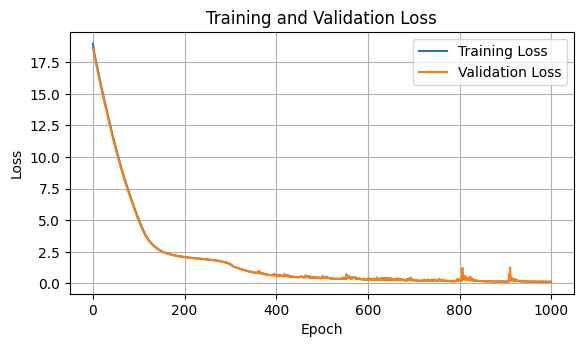

In [18]:
plot_train_val_loss(train_loss, test_loss)

In [20]:
os.makedirs(f"results/{results_folder}", exist_ok=True)
torch.save(train_loss, f"results/{results_folder}/train_loss.pt")
torch.save(test_loss, f"results/{results_folder}/test_loss.pt")

pickle.dump(activations, open(f"results/{results_folder}/activations.pkl", "wb"))

# Test

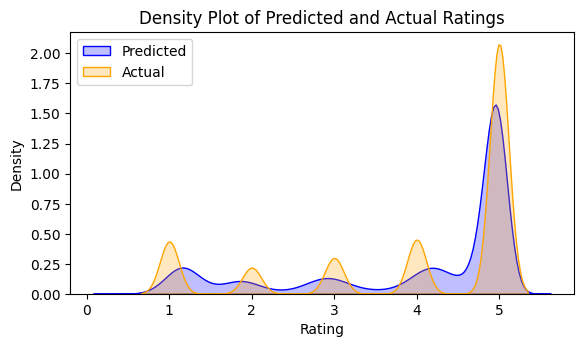

0.11389853805303574


In [21]:
model.load_state_dict(best_model)
best_loss, predictions = final_evaluation(model, test_edge_index, test_edge_weights, user_nodes, product_nodes, device, plot = True, print_test = False)
print(best_loss.item())

In [22]:
torch.save(predictions, f"results/{results_folder}/predictions.pt")

# Recomendations 

In [23]:
title_mapping = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = ["parent_asin", "title"])
prod_idx_to_id = {idx - offset: asin for asin, idx in prod_id_to_idx.items()}

In [24]:
# The pure random 
user_id = test_user_df.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Oldest Rookie, Big Leage dreams from a small Town Guy (basis for "The Rookie" movie)
Product 2: Tattoo Book - Yuelong Group Skulls Skeleton Design Tattoo Art Book Flash Sketch Supplies
Product 3: Revel Nail Dip Powder Glitter Colors Extravagant 2 Ounces
Product 4: Revel Nail Dip Powder Glitter Colors Infatuated 2 Ounces
Product 5: All 418 bodies Kinnikuman reprint Kinkeshi skin color ( Complete BOX Limited Edition full benefits )
Product 6: Five Guys Walk Into A Bar... (4CD) by The Faces (2004-07-05)
Product 7: Family Album #31 Hair Styling Book with DVD [Misc.]
Product 8: Wibbly Pig - Wibbly's Animal Tales
Product 9: Revel Nail Dip Powder 1oz - Glitter Color (Phoebe, 1oz)
Product 10: Oottati Skull Gun Rose Black Holographic Sketch Temporary Tattoo (2 Sheets)
tensor([4.8249, 4.8189, 4.8154, 4.8152, 4.8150, 4.8150, 4.8147, 4.8142, 4.8133,
        4.8120], device='cuda:0')


In [25]:
# The user with some data 
existing_test_users = test_user_df[test_user_df.user_id.isin(train_user_df.user_id)].copy()[["user_id"]]

In [26]:
user_id = existing_test_users.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Oldest Rookie, Big Leage dreams from a small Town Guy (basis for "The Rookie" movie)
Product 2: All 418 bodies Kinnikuman reprint Kinkeshi skin color ( Complete BOX Limited Edition full benefits )
Product 3: Wibbly Pig - Wibbly's Animal Tales
Product 4: Five Guys Walk Into A Bar... (4CD) by The Faces (2004-07-05)
Product 5: Family Album #31 Hair Styling Book with DVD [Misc.]
Product 6: A Fighter Pilot's Story Wwii VHS
Product 7: Tattoo Book - Yuelong Group Skulls Skeleton Design Tattoo Art Book Flash Sketch Supplies
Product 8: Revel Nail Dip Powder 1oz - Glitter Color (Phoebe, 1oz)
Product 9: Revel Nail Dip Powder Glitter Colors Infatuated 2 Ounces
Product 10: SHINEE JONGHYUN - Collection [THE STORY] Op.2 CD+Photo Booklet Sealed K-POP
tensor([4.8922, 4.8853, 4.8851, 4.8847, 4.8842, 4.8840, 4.8827, 4.8820, 4.8811,
        4.8810], device='cuda:0')


In [27]:
# count more than 10 purchases
min_unique_purchase = 10
item_count_df = test_user_edges.groupby("user_id").prod_idx.apply(lambda x: len(set(x))).reset_index()
dense_user_id = item_count_df[item_count_df["prod_idx"] >= min_unique_purchase][["user_id"]]

In [28]:
user_id = dense_user_id.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Oldest Rookie, Big Leage dreams from a small Town Guy (basis for "The Rookie" movie)
Product 2: Tattoo Book - Yuelong Group Skulls Skeleton Design Tattoo Art Book Flash Sketch Supplies
Product 3: Revel Nail Dip Powder Glitter Colors Extravagant 2 Ounces
Product 4: Revel Nail Dip Powder Glitter Colors Infatuated 2 Ounces
Product 5: All 418 bodies Kinnikuman reprint Kinkeshi skin color ( Complete BOX Limited Edition full benefits )
Product 6: Five Guys Walk Into A Bar... (4CD) by The Faces (2004-07-05)
Product 7: Family Album #31 Hair Styling Book with DVD [Misc.]
Product 8: Wibbly Pig - Wibbly's Animal Tales
Product 9: Revel Nail Dip Powder 1oz - Glitter Color (Phoebe, 1oz)
Product 10: Oottati Skull Gun Rose Black Holographic Sketch Temporary Tattoo (2 Sheets)
tensor([4.8249, 4.8189, 4.8154, 4.8152, 4.8150, 4.8150, 4.8147, 4.8142, 4.8133,
        4.8120], device='cuda:0')


# Analysing predictions

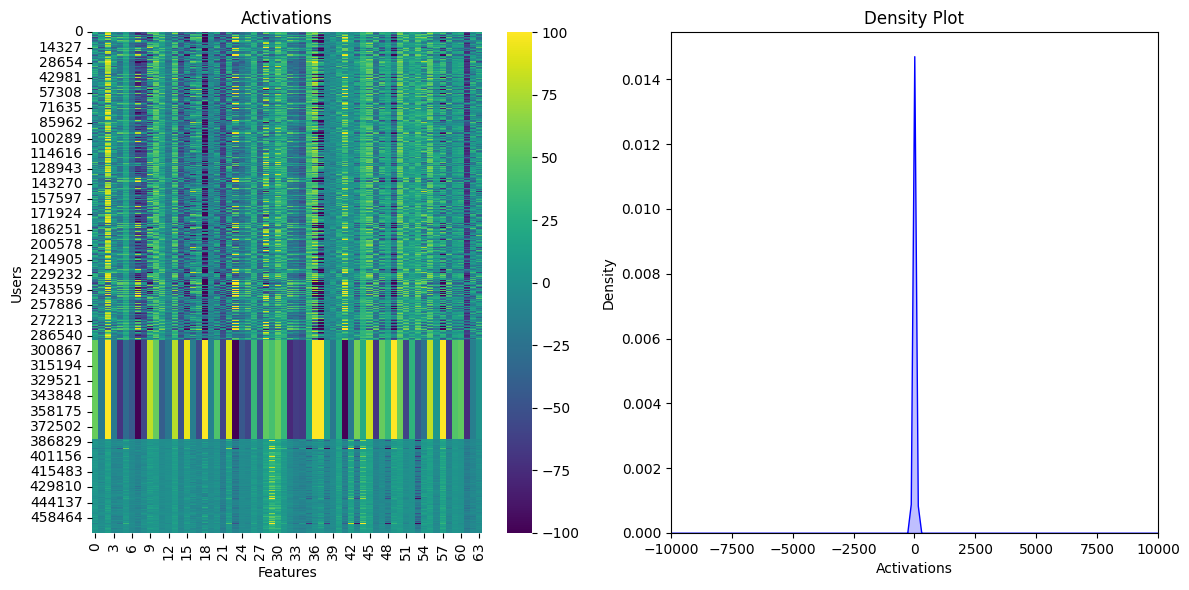

In [29]:
# Visualize activations of conv2 activation output
activations_of_interest = activations[model.conv2].detach().cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

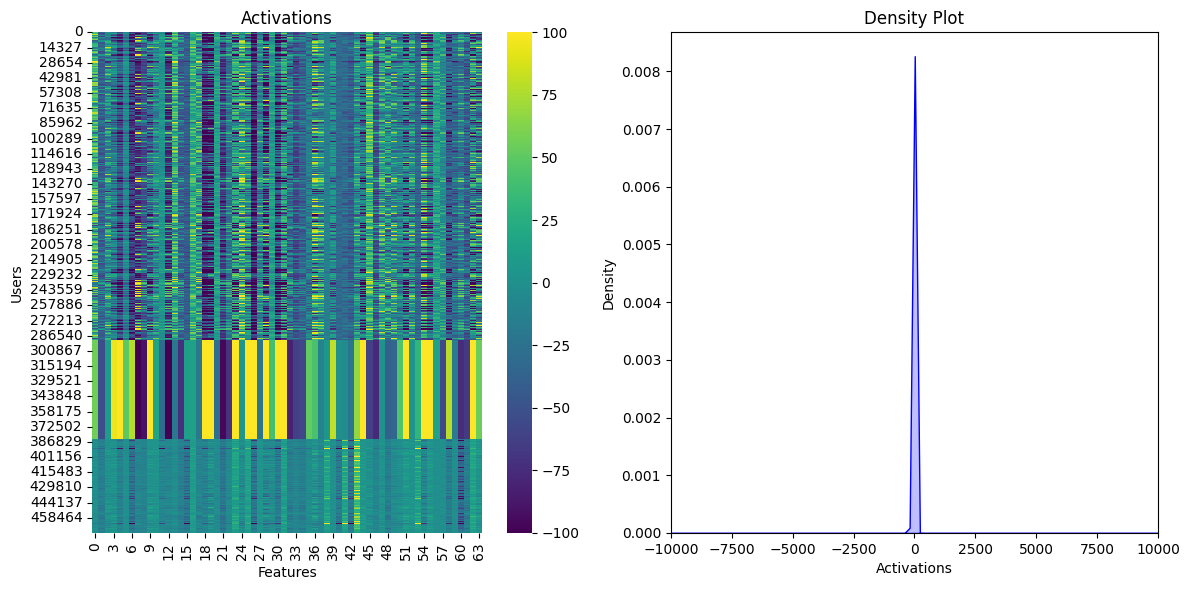

In [30]:
# Visualize activations of conv1 activation output
activations_of_interest = activations[model.conv1].detach().cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

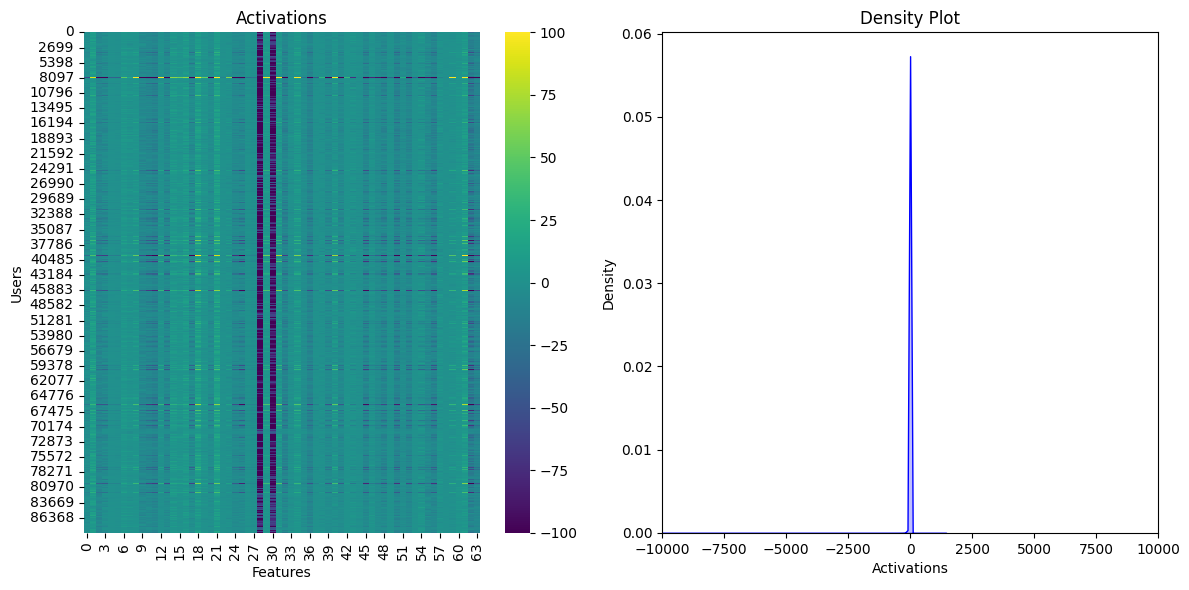

In [31]:
# Visualize activations of product_feature_transform activation output
activations_of_interest = activations[model.product_feature_transform].cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

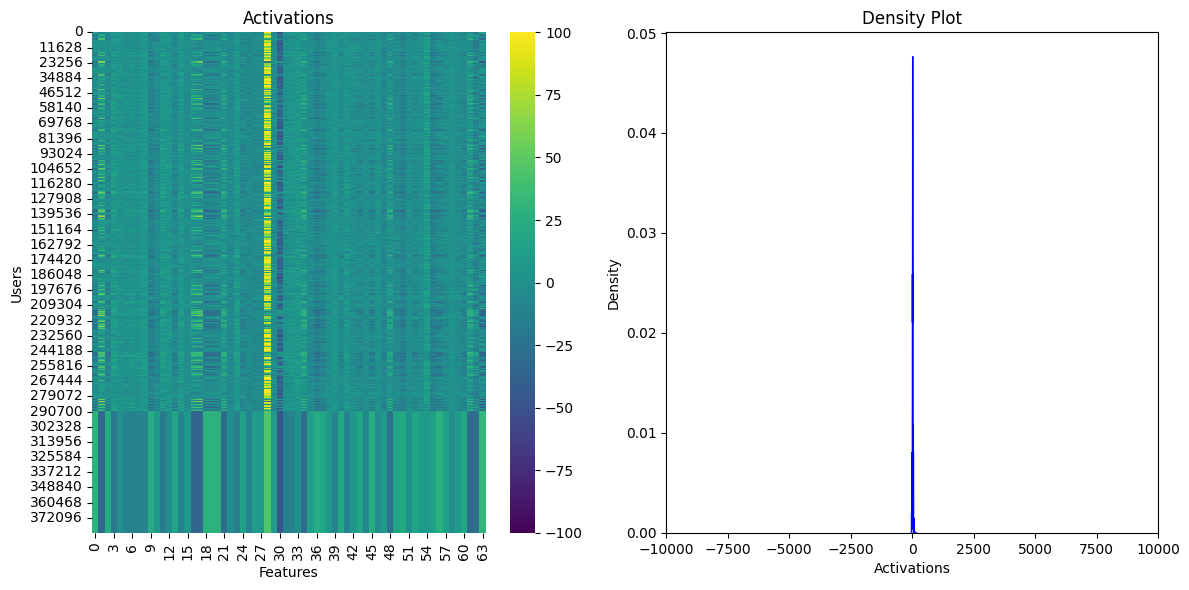

In [32]:
# Visualize activations of user_feature_transform activation output
activations_of_interest = activations[model.user_feature_transform].cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

# Metrics

In [33]:
product_idx_tensor = torch.tensor(list(prod_id_to_idx.values()), dtype=torch.long, device = device)
test_edges_grp = test_user_edges.groupby("user_idx").prod_idx.apply(list).reset_index()
test_edges_users = test_edges_grp.user_idx.to_list()

In [34]:
predictions = get_top_k_preds(model, test_edges_users, 10, 32, user_nodes, product_nodes, product_idx_tensor, device) # about 5 min to run
test_edges_grp["prediction"] = list(torch.vstack(predictions).cpu().numpy())
test_edges_grp["match_count"] = test_edges_grp.apply(lambda x: len(set(x.prod_idx).intersection(set(x.prediction))), axis = 1)

In [35]:
# Overall recall
(test_edges_grp["match_count"] / test_edges_grp.prod_idx.apply(len)).mean()

np.float64(0.0)

In [36]:
# Only those with prior history 
existing_test_edges_grp = test_edges_grp[test_edges_grp.user_idx.isin(train_user_df.user_id.apply(lambda x: user_id_to_idx[x]))]
(existing_test_edges_grp["match_count"] / existing_test_edges_grp.prod_idx.apply(len)).mean()

np.float64(0.0)

In [37]:
preds = set(y.item() for x in test_edges_grp.prediction for y in x)
len(preds)

21

In [38]:
test_edges_grp.to_parquet(f"results/{results_folder}/predictions.parquet")